#Pet-проект на тему: "Кредитный скоринг"

##Загрузка библиотек

In [ ]:
!pip install optuna -q

In [210]:
!pip install -U pydantic -q

In [211]:
!pip install shap -q

In [ ]:
!pip install -U ydata-profiling albumentations pydantic-settings

In [351]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score
import optuna

##Описание данных

**Предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.**

**Описания полей**


* client_id - идентификатор клиента

* education - уровень образования

* sex - пол заемщика

* age - возраст заемщика

* car - флаг наличия автомобиля

* car_type - флаг автомобиля иномарки

* decline_app_cnt - количество отказанных прошлых заявок

* good_work - флаг наличия “хорошей” работы

* bki_request_cnt - количество запросов в БКИ

* home_address - категоризатор домашнего адреса

* work_address - категоризатор рабочего адреса

* income - доход заемщика

* foreign_passport - наличие загранпаспорта

* sna - связь заемщика с клиентами банка

* first_time - давность наличия информации о заемщике

* score_bki - скоринговый балл по данным из БКИ

* region_rating - рейтинг региона

* app_date - дата подачи заявки

* default - флаг дефолта по кредиту

**Моей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента.**

##Импорт данных

In [214]:
df = pd.read_csv('data.csv')
print('Размерность датасета: ', df.shape)

Размерность датасета:  (73799, 19)


##Предварительный анализ данных

In [215]:
df.head(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [217]:
df.describe()

client_id           age  decline_app_cnt     good_work  \
count   73799.000000  73799.000000     73799.000000  73799.000000   
mean    55137.965094     39.280641         0.275749      0.164894   
std     31841.921168     11.520378         0.804272      0.371087   
min         1.000000     21.000000         0.000000      0.000000   
25%     27440.500000     30.000000         0.000000      0.000000   
50%     55274.000000     37.000000         0.000000      0.000000   
75%     82758.500000     48.000000         0.000000      0.000000   
max    110147.000000     72.000000        33.000000      1.000000   

          score_bki  bki_request_cnt  region_rating  home_address  \
count  73799.000000     73799.000000   73799.000000  73799.000000   
mean      -1.904724         2.000339      56.725701      1.575509   
std        0.498231         2.252073      13.055717      0.527631   
min       -3.624586         0.000000      20.000000      1.000000   
25%       -2.259534         0.000000      50.000000      1.000000   
50%       -1.920823         1.000000      50.000000      2.000000   
75%       -1.569831         3.000000      60.000000      2.000000   
max        0.199773        53.000000      80.000000      3.000000   

       work_address          income           sna    first_time       default  
count  73799.000000    73799.000000  73799.000000  73799.000000  73799.000000  
mean       2.496280    41099.775417      1.733330      2.765458      0.126994  
std        0.689818    46166.322400      1.123622      1.009463      0.332968  
min        1.000000     1000.000000      1.000000      1.000000      0.000000  
25%        2.000000    20000.000000      1.000000      2.000000      0.000000  
50%        3.000000    30000.000000      1.000000      3.000000      0.000000  
75%        3.000000    48000.000000      2.000000      4.000000      0.000000  
max        3.000000  1000000.000000      4.000000      4.000000      1.000000

In [218]:
df[["home_address", "work_address"]] = df[["home_address", "work_address"]].astype('object')
df["decline_app_cnt"] = df["decline_app_cnt"].astype('int')

In [219]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Резюме по предварительному анализу:** в выборке 73799 клиентов. Всего 19 предикторов, из них 1 - временной ряд, 3 бинарных, 8 категориальных и 7 числовых.

Таргет распределен неравномерно (дефолт по кредиту встречается гораздо реже)

 Всего пропусков 272 (0.4%), все пропуски в переменной education.

 client_id уникальный числовой признак, который в данной ситуации не несет пользы.

##Составление гипотез

1. **Образование влияет на вероятность дефолта.** Заемщики с более высоким
уровнем образования могут быть более финансово дисциплинированными, что снижает вероятность дефолта.

2. **Пол клиента может влиять на вероятность дефолта.** Мужчины и женщины могут различаться в подходах к управлению долгами и финансами, что может повлиять на риск дефолта.

3. **Возраст заемщика влияет на вероятность дефолта.** Молодые заемщики могут быть менее финансово стабильными, тогда как более пожилые клиенты могут быть более ответственными в отношении своих долгов.

4. **Наличие автомобиля и его тип могут коррелировать с финансовой стабильностью.** Заемщики, имеющие автомобили, особенно иномарки, могут иметь более высокий доход и меньший риск дефолта.

5. **Количество отказанных заявок в прошлом является индикатором финансовой дисциплины.** Чем больше отказов, тем выше вероятность того, что клиент испытывает финансовые затруднения.

6. **Наличие "хорошей" работы снижает вероятность дефолта.** Заемщики с устойчивой занятостью, вероятно, более платежеспособны.

7. **Доход клиента напрямую влияет на его способность погашать кредиты.** Чем выше доход, тем ниже вероятность дефолта.

8. **Рейтинг региона влияет на кредитоспособность заемщика.** В регионах с более высоким рейтингом люди могут быть более финансово стабильными и иметь меньший риск дефолта.

9. **Давность информации о заемщике в базе данных (first_time) может указывать на его стабильность и опыт в кредитных операциях.** Клиенты, давно работающие с банком, могут иметь более низкий риск дефолта.

##Анализ по переменным

###education

<Axes: title={'center': 'Распределение уровня образования'}, xlabel='education'>

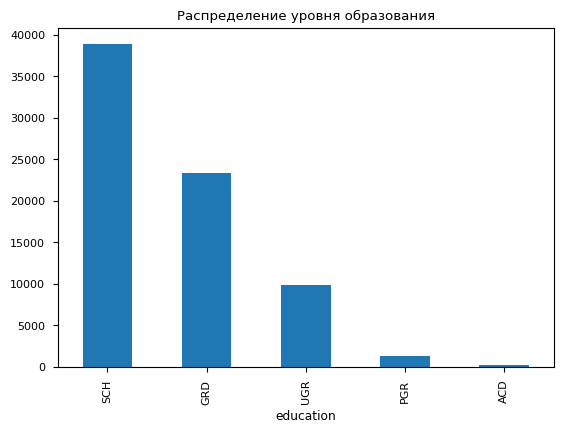

In [220]:
df['education'].value_counts().plot.bar(title='Распределение уровня образования')

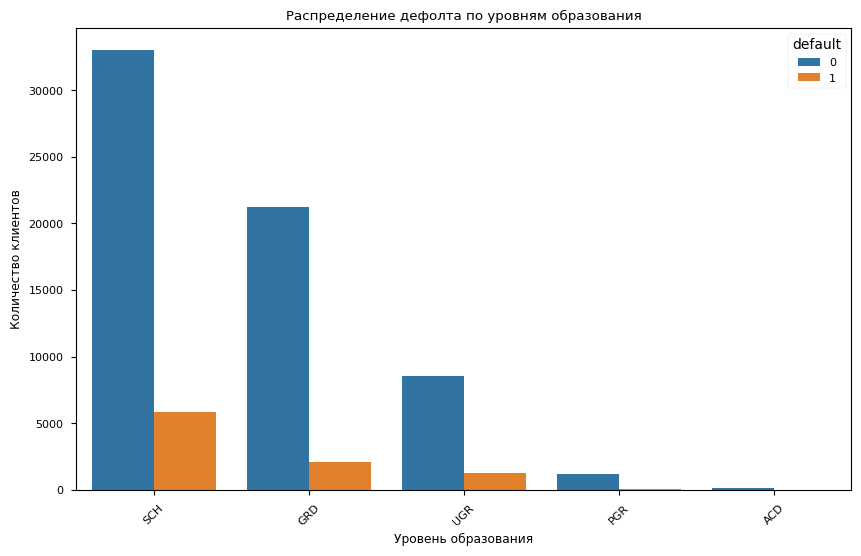

In [221]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='education', hue='default')
plt.title('Распределение дефолта по уровням образования')
plt.xlabel('Уровень образования')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.show()

In [222]:
df.groupby('education')['default'].mean().sort_values(ascending=False)

education
SCH    0.150592
UGR    0.131520
GRD    0.090092
PGR    0.064439
ACD    0.041237
Name: default, dtype: float64

**Резюме:** Уровень образования влияет на долю дефолта. Гипотеза подтвердилась.

###sex

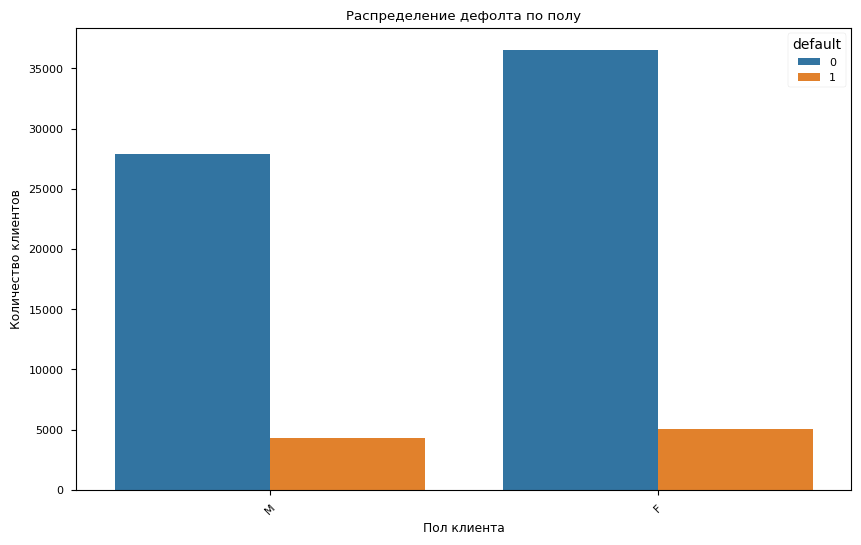

In [223]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sex', hue='default')
plt.title('Распределение дефолта по полу')
plt.xlabel('Пол клиента')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.show()

In [224]:
df.groupby('sex')['default'].mean().sort_values(ascending=False)

sex
M    0.134411
F    0.121241
Name: default, dtype: float64

**Резюме**: Пол не сильно влияет на вероятность возврата кредита.

###age

<Figure size 1000x600 with 0 Axes>

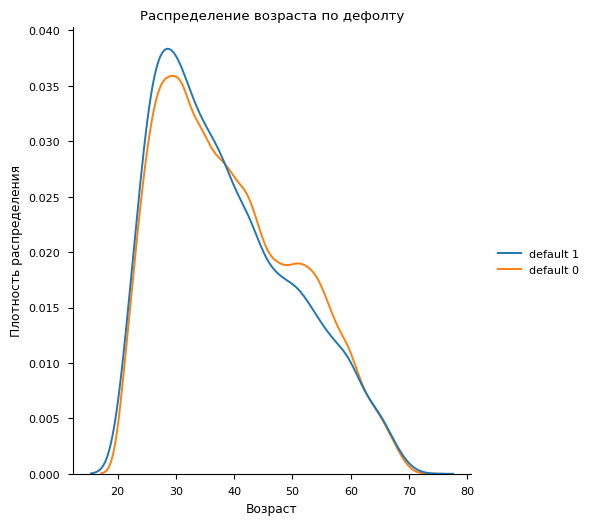

In [225]:
# График распределения возраста по дефолту
plt.figure(figsize=(10, 6))
sns.displot(
    {"default 1": df[df["default"] == 1]["age"],
     "default 0": df[df["default"] == 0]["age"]},
    kind = "kde",
    common_norm=False
)
plt.title('Распределение возраста по дефолту')
plt.xlabel('Возраст')
plt.ylabel('Плотность распределения')
plt.show()


In [226]:
df.groupby('default')['age'].mean()

default
0    39.390504
1    38.525395
Name: age, dtype: float64

**Резюме:** Возраст "хороших" заемщиков в среднем больше, чем возраст "плохих". Гипотеза подтвердилась.

###car и car_type

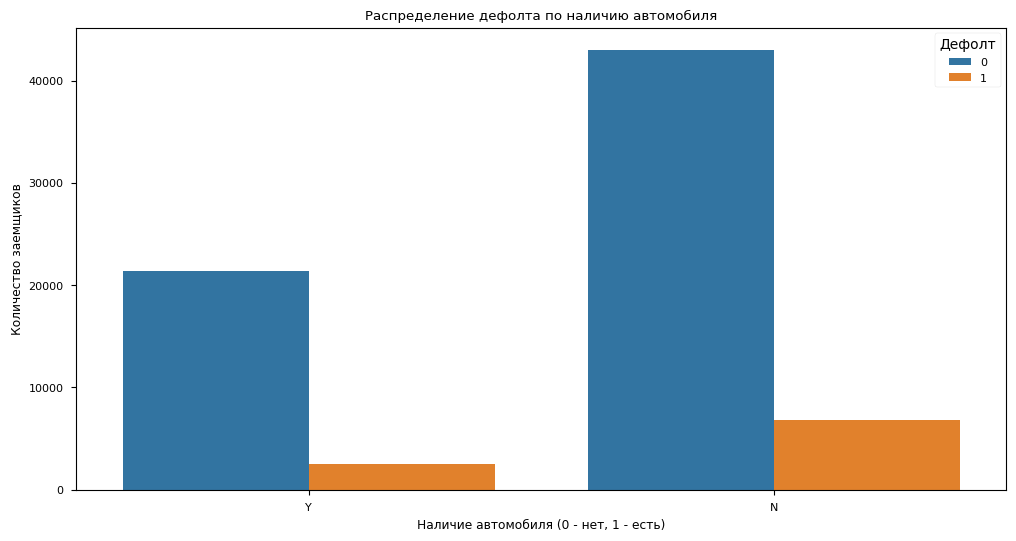

In [227]:
# График распределения дефолта по наличию автомобиля
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='car', hue='default')
plt.title('Распределение дефолта по наличию автомобиля')
plt.xlabel('Наличие автомобиля (0 - нет, 1 - есть)')
plt.ylabel('Количество заемщиков')
plt.legend(title='Дефолт')
plt.show()

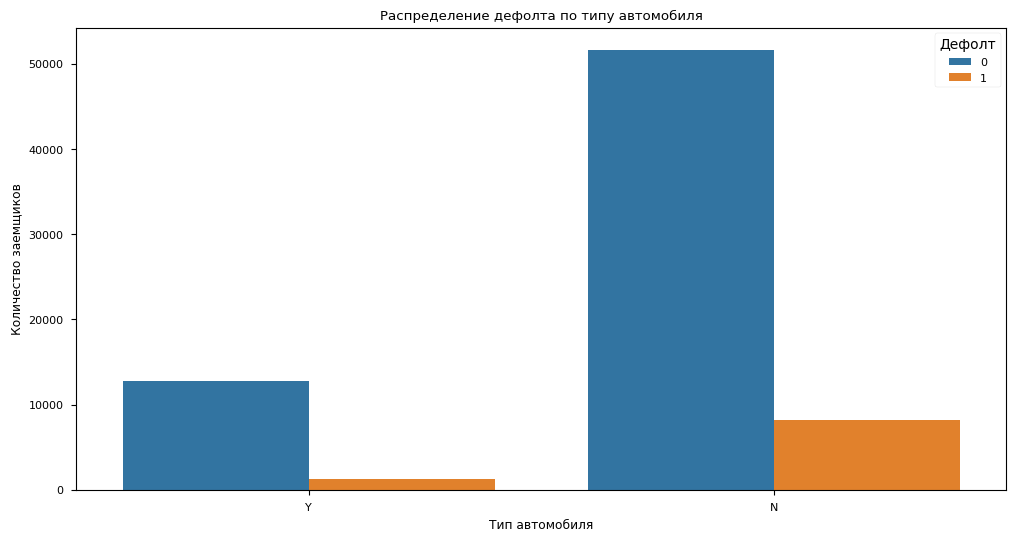

In [228]:
# График распределения дефолта по типу автомобиля
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='car_type', hue='default')
plt.title('Распределение дефолта по типу автомобиля')
plt.xlabel('Тип автомобиля')
plt.ylabel('Количество заемщиков')
plt.legend(title='Дефолт')
plt.show()

**Резюме:** колонки car и car_type достаточно сильно коррелированы и, похоже, не несут важной информации для предсказания дефолта. Возможно, в дальнейшем стоит оставить только одну колонку.

###decline_app_cnt

<ipython-input-229-75360d6ef7ed>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='default', y='decline_app_cnt', palette='Set2')


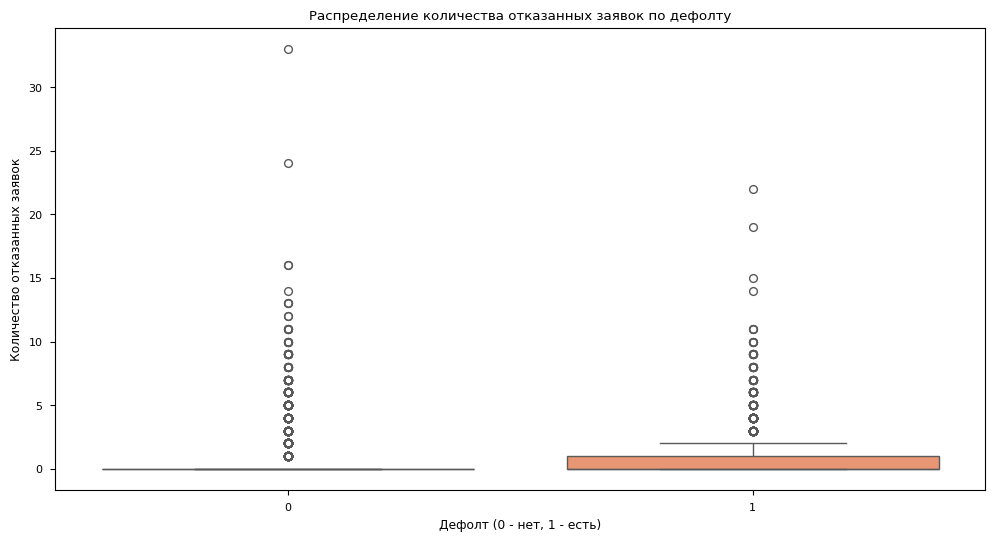

In [229]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='default', y='decline_app_cnt', palette='Set2')
plt.title('Распределение количества отказанных заявок по дефолту')
plt.xlabel('Дефолт (0 - нет, 1 - есть)')
plt.ylabel('Количество отказанных заявок')
plt.show()

In [230]:
df.groupby('default')['decline_app_cnt'].mean()

default
0    0.240877
1    0.515472
Name: decline_app_cnt, dtype: float64

**Резюме:** Выбросов очень много, в дальнейшем попробуем прологорифмировать. В среднем, количество отказных заявок у "плохих" заемщиков выше.

###income

<Figure size 1000x600 with 0 Axes>

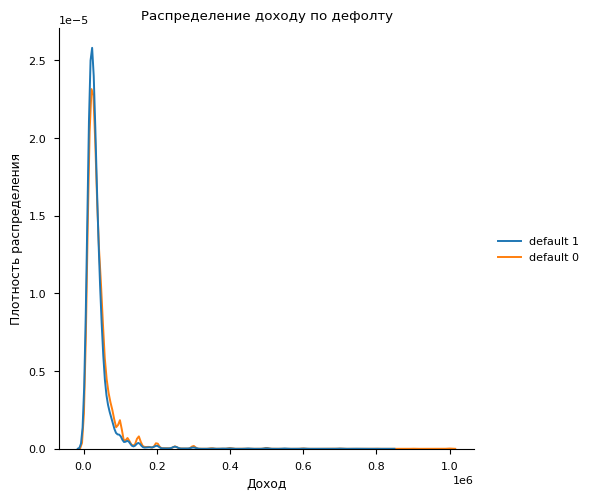

In [231]:
plt.figure(figsize=(10, 6))
sns.displot(
    {"default 1": df[df["default"] == 1]["income"],
     "default 0": df[df["default"] == 0]["income"]},
    kind = "kde",
    common_norm=False
)
plt.title('Распределение доходу по дефолту')
plt.xlabel('Доход')
plt.ylabel('Плотность распределения')
plt.show()


In [232]:
df.groupby('default')['income'].mean()

default
0    41799.713288
1    36288.113316
Name: income, dtype: float64

**Резюме**: В среднем, люди с высоким доходом чаще возвращают кредиты.

###good_work

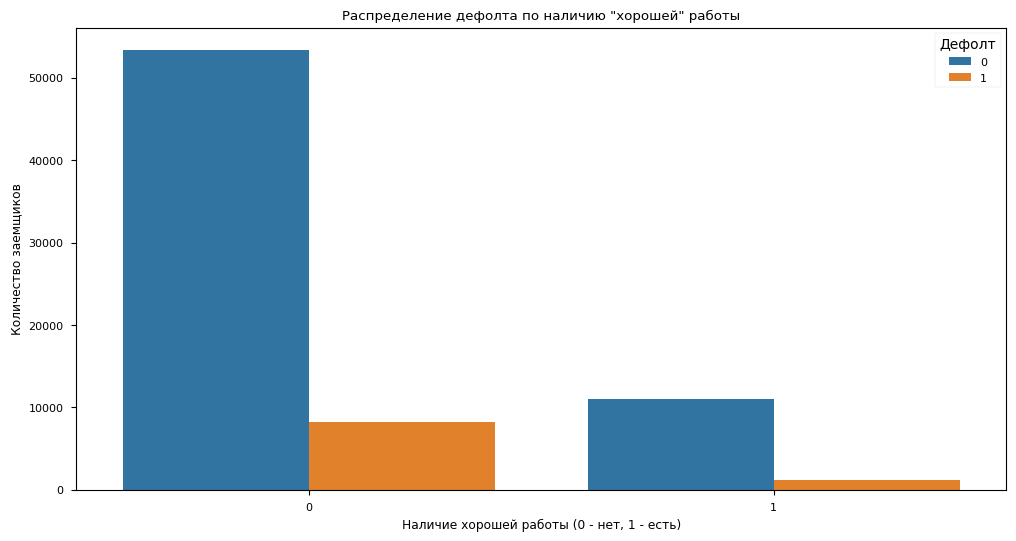

In [233]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='good_work', hue='default')
plt.title('Распределение дефолта по наличию "хорошей" работы')
plt.xlabel('Наличие хорошей работы (0 - нет, 1 - есть)')
plt.ylabel('Количество заемщиков')
plt.legend(title='Дефолт')
plt.show()

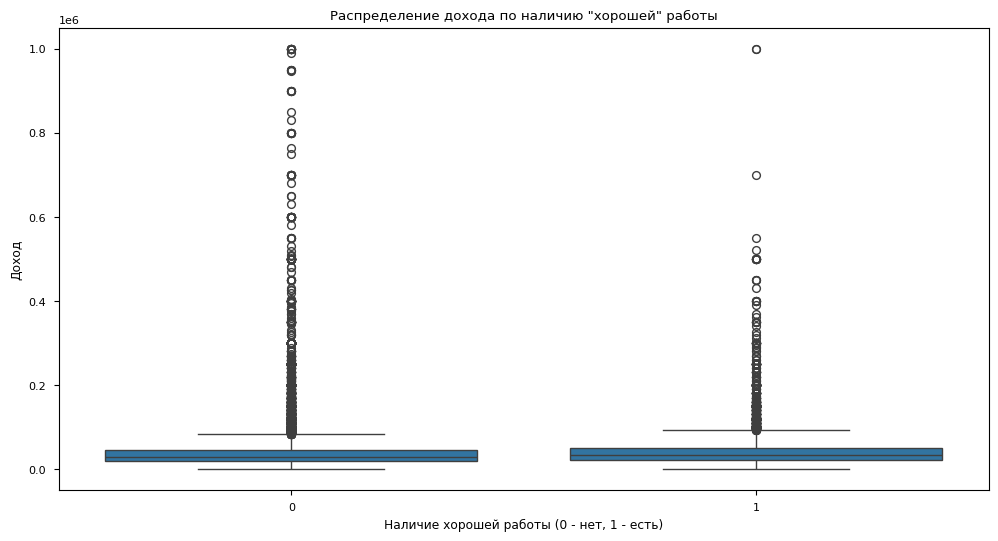

In [234]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='good_work', y='income')
plt.title('Распределение дохода по наличию "хорошей" работы')
plt.xlabel('Наличие хорошей работы (0 - нет, 1 - есть)')
plt.ylabel('Доход')
plt.show()

In [235]:
df.groupby('default')['good_work'].mean()

default
0    0.171031
1    0.122706
Name: good_work, dtype: float64

**Резюме**: "Хорошие" заемщики чаще имеют хорошую работу.

###region_rating

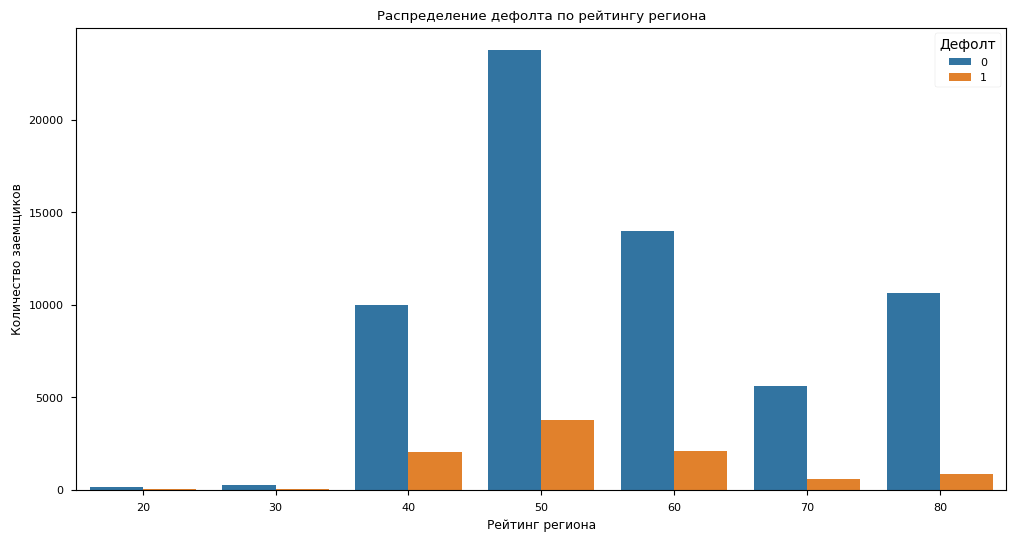

In [236]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='region_rating', hue='default')
plt.title('Распределение дефолта по рейтингу региона')
plt.xlabel('Рейтинг региона')
plt.ylabel('Количество заемщиков')
plt.legend(title='Дефолт')
plt.show()

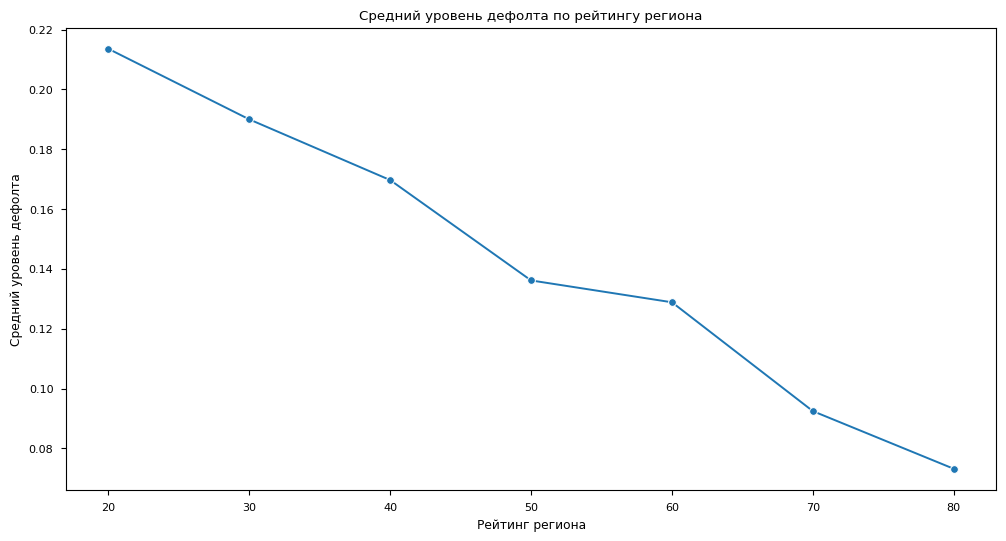

In [237]:
plt.figure(figsize=(12, 6))
default_rate_by_region = df.groupby('region_rating')['default'].mean()
sns.lineplot(x=default_rate_by_region.index, y=default_rate_by_region.values, marker='o')
plt.title('Средний уровень дефолта по рейтингу региона')
plt.xlabel('Рейтинг региона')
plt.ylabel('Средний уровень дефолта')
plt.show()

**Резюме:** Люди из регионов с высоким рейтингом чаще возвращают кредиты.

###first_time

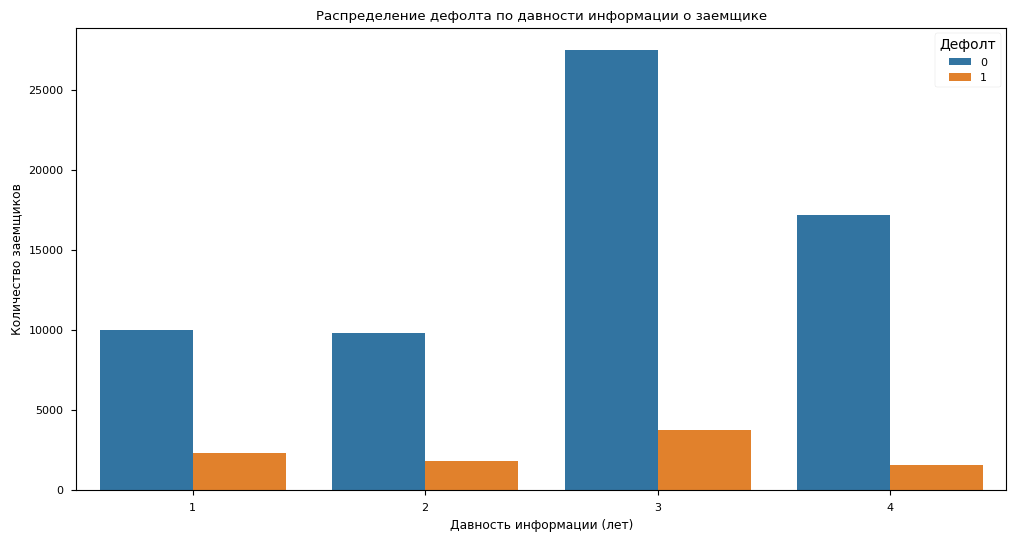

In [238]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='first_time', hue='default')
plt.title('Распределение дефолта по давности информации о заемщике')
plt.xlabel('Давность информации (лет)')
plt.ylabel('Количество заемщиков')
plt.legend(title='Дефолт')
plt.show()

In [239]:
df.groupby('default')['first_time'].mean()

default
0    2.806106
1    2.486022
Name: first_time, dtype: float64

**Резюме:** Пока что нельзя сказать, что давность информации о заемщике сильно влияет на вероятность дефолта. По корреляционному анализу также нельзя сделать такого вывода.

###app_date

In [240]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [241]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [242]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

<ipython-input-243-1e95668b31db>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')
<ipython-input-243-1e95668b31db>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=df['app_date'].dt.month, y='default', palette="PuBu");


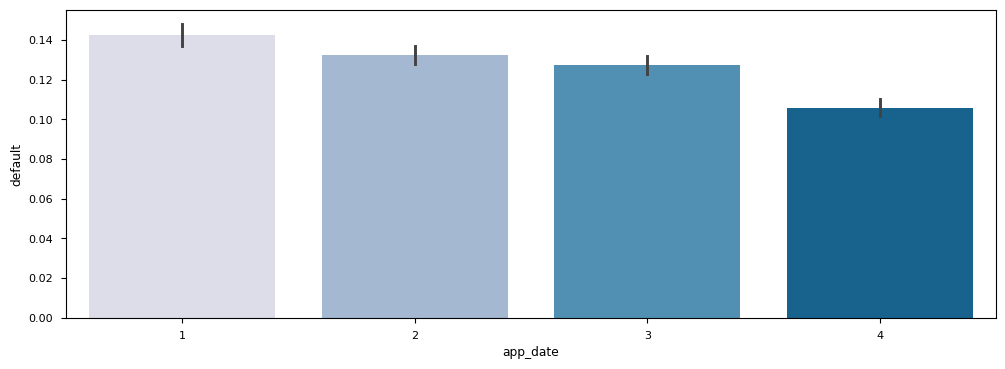

In [243]:
# Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=df, x=df['app_date'].dt.month, y='default', palette="PuBu");

<Axes: xlabel='client_id', ylabel='days'>

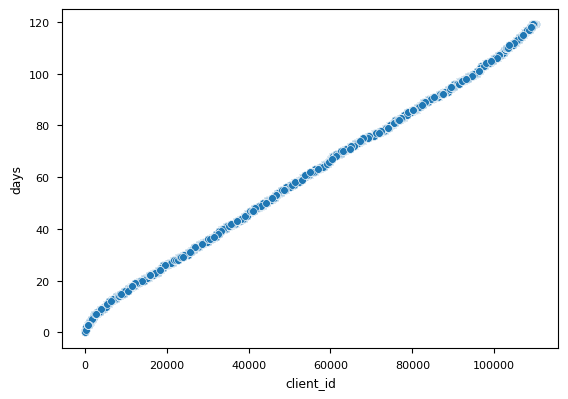

In [244]:
# Выясняем, что в банке велась сквозная нумерация клиентов в зависимости от дня обращения
sns.scatterplot(x='client_id',y='days',data=df)

In [245]:
df.drop('days', axis=1, inplace=True)

##Feature engineering

In [246]:
# заполним пропуски в education
# переменной education 307 (0.4%) пропущенных значений
# заполним пропуски самым популярным значением
df['education'] = df['education'].fillna('SCH')

In [247]:
#Удалим колонку client_id
df = df.drop('client_id', axis=1)

In [248]:
#Создадим колонки со днем и месяцем подачи заявки
df['day'] = df['app_date'].dt.day
df['month'] = df['app_date'].dt.month

In [249]:
df.drop('app_date', axis=1, inplace=True)

In [250]:
#Выделим числовые и категориальные признаки
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns

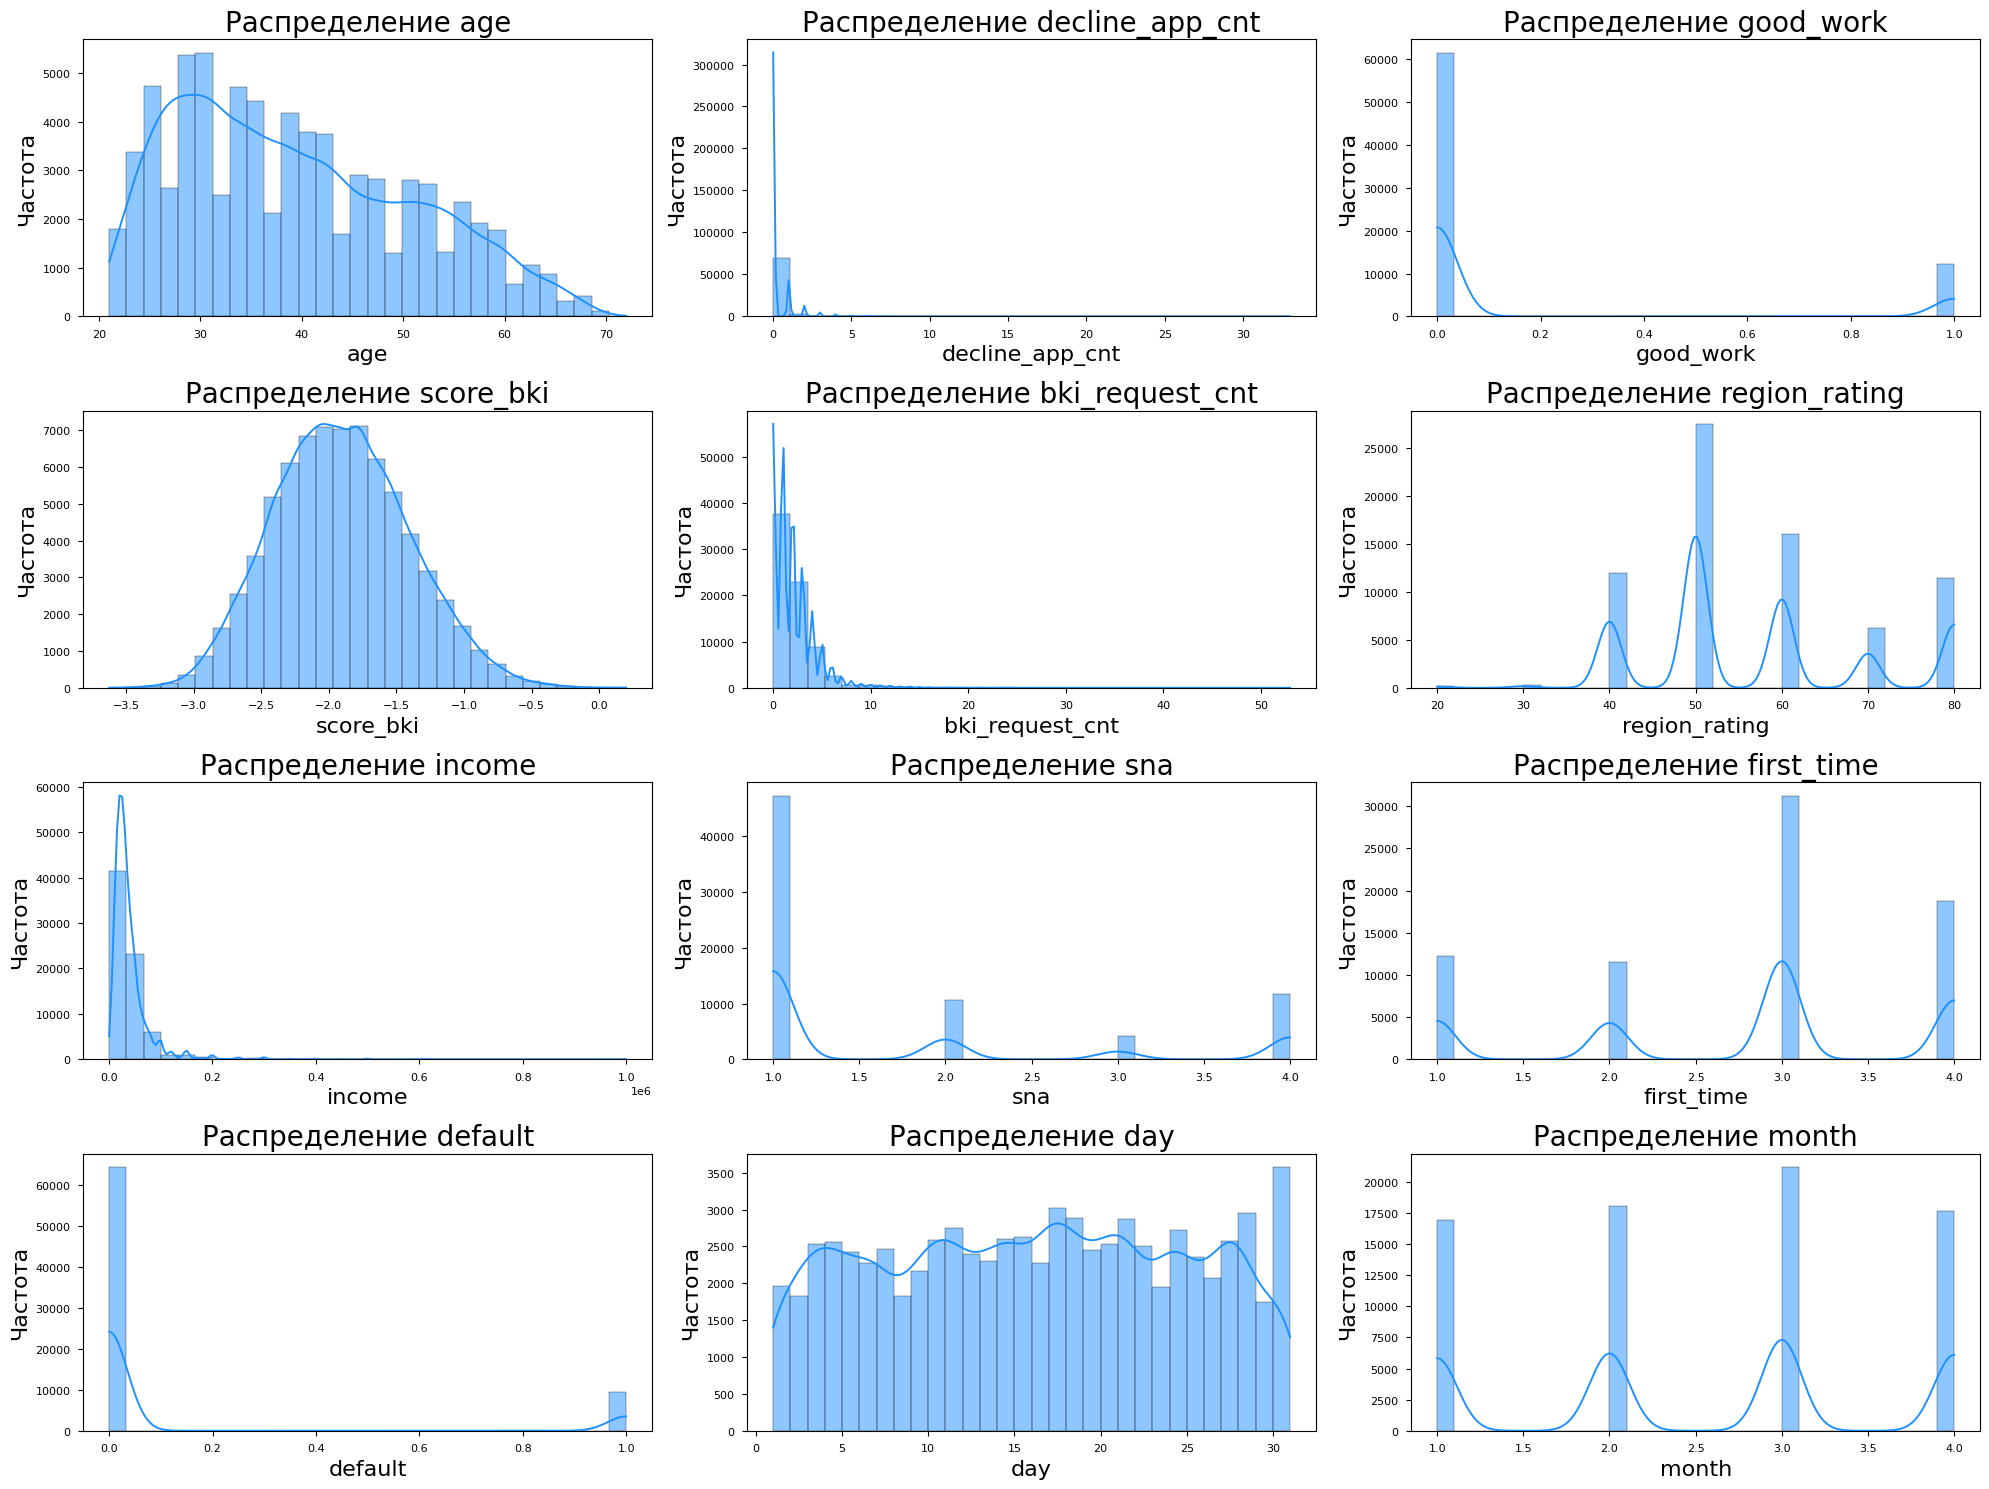

In [251]:
#Еще раз взглянем на распределения переменных
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='dodgerblue')
    plt.title(f'Распределение {col}', fontsize=20)
    plt.xlabel(col, fontsize=16)
    plt.ylabel('Частота', fontsize=16)

plt.tight_layout()
plt.show()

In [252]:
#Закодируем категориальные признаки
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols).astype('int')

In [253]:
#Отлогорифмируем некоторые колонки, которые распределены не нормально
for i in ["decline_app_cnt", "income", "age", "bki_request_cnt"]:
    df[i] = np.log1p(df[i])

##Baseline

In [314]:
#Разобьем выборку на train и test, используя стратификацию по целевой переменной
X_train, X_test, y_train, y_test = train_test_split(df.drop('default', axis=1), df['default'], test_size=0.2, random_state=42, stratify=df['default'])
X_train = pd.DataFrame(X_train, columns=df.drop('default', axis=1).columns)
X_test = pd.DataFrame(X_test, columns=df.drop('default', axis=1).columns)

Добавим еще вспомогательных переменных для train и test по отдельности, чтобы избежать data leak.

In [255]:
#Средний доход с учетом рейтинга региона
mean_income_by_region = X_train.groupby('region_rating')['income'].mean().to_dict()
X_train['mean_income_by_region'] = X_train['region_rating'].map(mean_income_by_region)

In [256]:
mean_income_by_region = X_test.groupby('region_rating')['income'].mean().to_dict()
X_test['mean_income_by_region'] = X_test['region_rating'].map(mean_income_by_region)

In [257]:
#Средний доход с учетом возраста
mean_income_by_age = X_train.groupby('age')['income'].mean().to_dict()
X_train['mean_income_by_age'] = X_train['age'].map(mean_income_by_age)

mean_income_by_age = X_test.groupby('age')['income'].mean().to_dict()
X_test['mean_income_by_age'] = X_test['age'].map(mean_income_by_age)

In [258]:
X_train.head()

age  decline_app_cnt  good_work  score_bki  bki_request_cnt  \
19791  3.912023         0.000000          1         -1         1.386294   
49335  3.218876         0.000000          0         -1         0.000000   
41747  3.218876         0.000000          0         -2         0.693147   
62167  3.555348         0.000000          0         -2         0.693147   
63663  4.077537         0.693147          0         -2         0.000000   

       region_rating     income  sna  first_time  day  ...  home_address_1  \
19791             50  11.002117    1           3   11  ...               1   
49335             50   9.903538    1           3   16  ...               1   
41747             80  10.714440    1           2   14  ...               0   
62167             50  10.308986    4           2   18  ...               1   
63663             40  10.308986    1           3   21  ...               0   

       home_address_2  home_address_3  work_address_1  work_address_2  \
19791               0               0               1               0   
49335               0               0               0               1   
41747               1               0               0               0   
62167               0               0               0               1   
63663               1               0               0               0   

       work_address_3  foreign_passport_N  foreign_passport_Y  \
19791               0                   0                   1   
49335               0                   1                   0   
41747               1                   1                   0   
62167               0                   1                   0   
63663               1                   1                   0   

       mean_income_by_region  mean_income_by_age  
19791              10.203766           10.389447  
49335              10.203766           10.292302  
41747              10.785369           10.292302  
62167              10.203766           10.424483  
63663              10.163882           10.064072  

[5 rows x 32 columns]

Также стандартизируем признаки.

In [260]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Наконец, обучим первую модель логистической регрессии.

In [268]:
model = LogisticRegression()

model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

##Оценка baseline-модели

Accuracy: 0.872289972899729
Precision: 0.44954128440366975
Recall: 0.026147278548559232
F1 Score: 0.049420070600100854


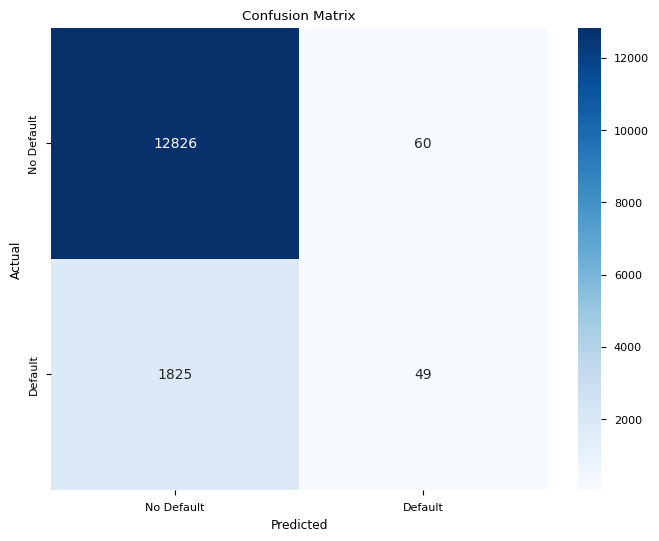

In [272]:
# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Выводим метрики
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

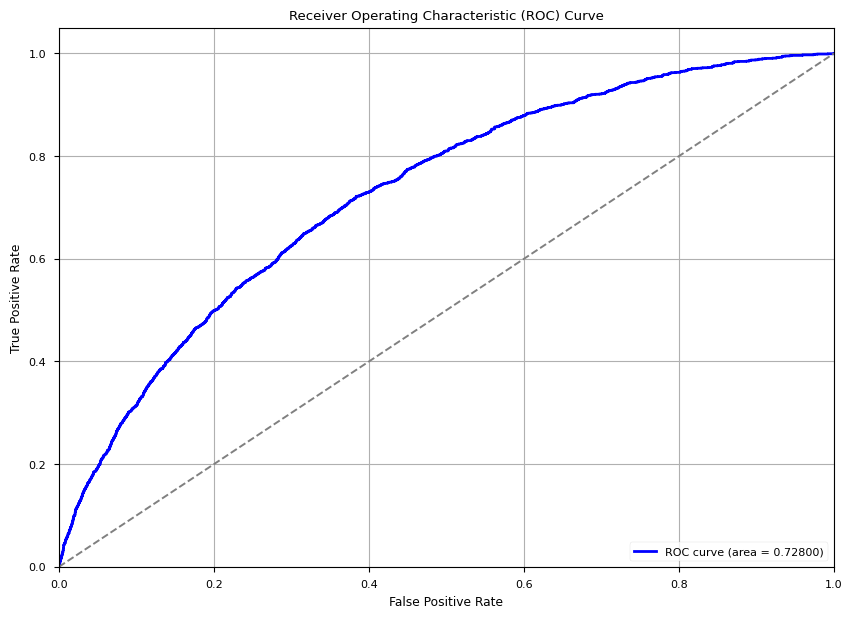

In [275]:
#Также построим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)


plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

***Резюме*** - прекрасный пример несостоятельности метрики ROC-AUC на несбалансированных данных. Мы абсолютно не угадали дефолтных клиентов, тем самым обеспечили себе огромную ошибку второго рода и как следствие колосальный убыток, но ROC-AUC у нас высокий.

О плохом качестве модели также сигнализирует низкий F1-score.

##Поиск оптимальных гиперпараметров модели

In [ ]:
def objective(trial):

    param ={
        'C': trial.suggest_categorical('C',[0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]),
        'solver': trial.suggest_categorical('solver',['sag', 'saga']),
        'penalty': trial.suggest_categorical('penalty',['l2', 'none']),
        'max_iter': trial.suggest_int('max_iter',100, 1000),
        'class_weight': trial.suggest_categorical('class_weight',['balanced', None]),
        'l1_ratio': trial.suggest_float('l1_ratio',0.0, 1.0),
        'multi_class': trial.suggest_categorical('multi_class', ['auto', 'ovr', 'multinomial']),
        'tol': trial.suggest_float('tol', 1e-4, 1e-1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 1, 3),
        'warm_start': trial.suggest_categorical('warm_start', [True, False])
    }

    score = cross_val_score(LogisticRegression(**param, verbose=False, n_jobs=-1),
                            X_train, y_train, cv=3, scoring='f1', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

In [296]:
print(study.best_trial)

FrozenTrial(number=478, state=TrialState.COMPLETE, values=[0.33519381631787576], datetime_start=datetime.datetime(2024, 9, 14, 15, 46, 35, 640656), datetime_complete=datetime.datetime(2024, 9, 14, 15, 46, 36, 660426), params={'C': 10.0, 'solver': 'sag', 'penalty': 'none', 'max_iter': 939, 'class_weight': 'balanced', 'l1_ratio': 0.8299468501297746, 'multi_class': 'ovr', 'tol': 0.09467915522743152, 'fit_intercept': True, 'intercept_scaling': 2.088745276320611, 'warm_start': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': CategoricalDistribution(choices=(0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0)), 'solver': CategoricalDistribution(choices=('sag', 'saga')), 'penalty': CategoricalDistribution(choices=('l2', 'none')), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'class_weight': CategoricalDistribution(choices=('balanced', None)), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'multi_class': CategoricalDistributio

**Резюме:** метрика f1 подросла почти в 10 раз, что вселяет надежду на то, что модель теперь будет работать эффективнее

In [317]:
model = LogisticRegression(**{'C': 10.0,
                             'solver': 'sag',
                             'penalty': 'none',
                             'max_iter': 939,
                             'class_weight': 'balanced',
                             'l1_ratio': 0.8299468501297746,
                             'multi_class': 'ovr',
                             'tol': 0.09467915522743152,
                             'fit_intercept': True,
                             'intercept_scaling': 2.088745276320611,
                             'warm_start': True})

model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


##Оценка качества модели на оптимальных параметрах

Accuracy: 0.7197154471544716
Precision: 0.2435984590981192
Recall: 0.5736392742796158
F1 Score: 0.3419755050103388


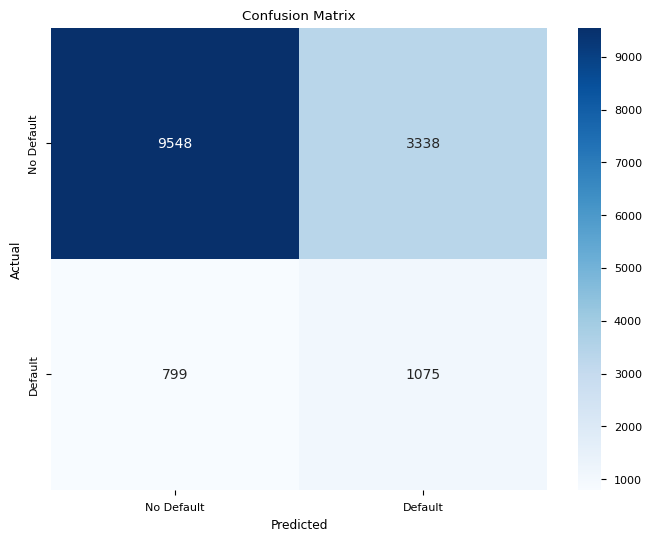

In [318]:
# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Выводим метрики
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

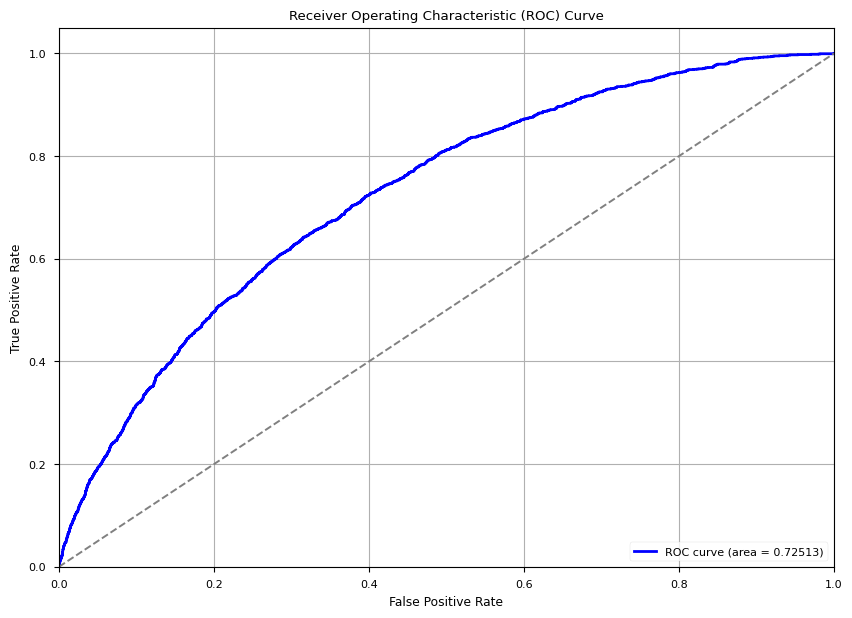

In [319]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)


plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Резюме:** все метрики подросли по сравнению с первой моделью, кроме accuracy и precision. Мы можем ожидать не такой провал по ошибке второго рода как на первой модели. Ну и точность модели precision просела тоже в том числе потому что модель стала работать лучше и в FP полились клиенты из TN.

##Оценка важности признаков с помощью shap

In [320]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


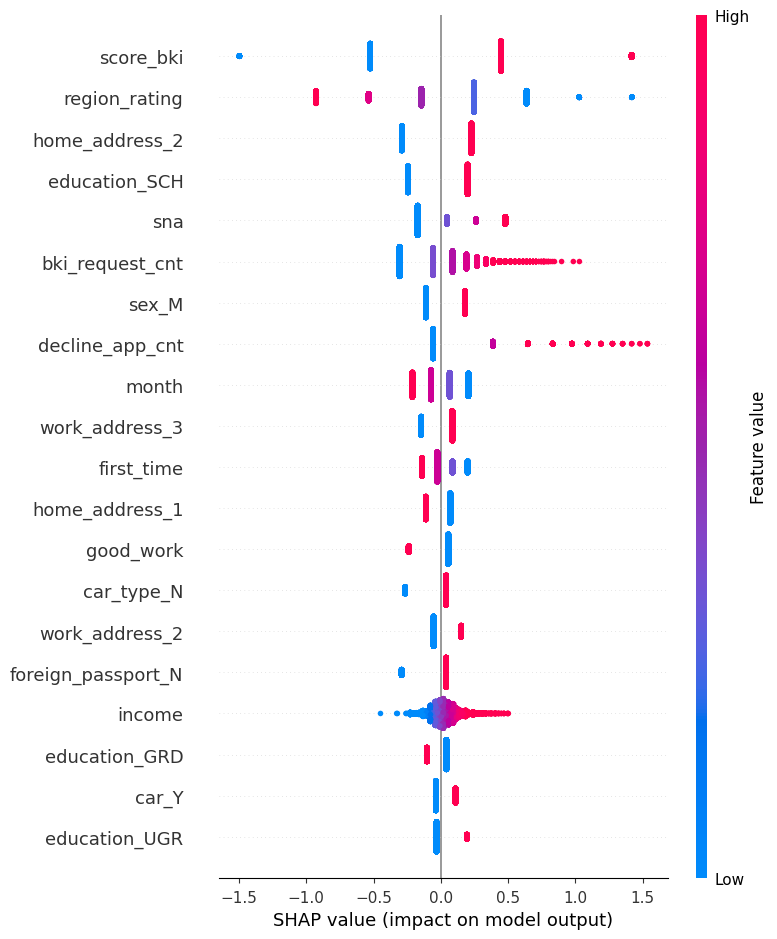

In [321]:
shap.summary_plot(shap_values, X_test)